In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
import tarfile
tar = tarfile.open("drive/My Drive/Datasets/Dataset.tar.gz")
tar.extractall()
tar.close()

In [11]:
import cv2
import numpy as np
from skimage import data, segmentation, color
from skimage.future import graph
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import sys
import torch.nn.init
import os
from IPython.display import clear_output as clr

In [14]:
nu=1
use_cuda = False
class MyNet(nn.Module):
    def __init__(self,input_dim, nlast = 500):
        super(MyNet, self).__init__()
        self.conv1 = nn.Conv2d(input_dim, 100, kernel_size=3, stride=1, padding=1 )
        self.bn1 = nn.BatchNorm2d(100)
        self.conv2 = []
        self.bn2 = []
        for i in range(nu-1):
            self.conv2.append( nn.Conv2d(100, 100, kernel_size=3, stride=1, padding=1 ) )
            self.bn2.append( nn.BatchNorm2d(100) )
        
        self.conv3 = nn.Conv2d(100,nlast, kernel_size=1, stride=1, padding=0 )
        self.bn3 = nn.BatchNorm2d(nlast)
        
        self.conv4 = nn.Conv2d(100,1, kernel_size=1, stride=1, padding=0 )
        self.bn4 = nn.BatchNorm2d(1)

    def forward(self, x):
#         print(self.conv2[0])
#         print(self.conv2[1])
        x = self.conv1(x)
        x = F.relu( x )
        x = self.bn1(x)
        for i in range(nu-1):
#             print(x.shape)
            x = self.conv2[i](x)
            x = F.relu( x )
#             print(x.shape)
            x = self.bn2[i](x)
#             print(x.shape)
        
        y = self.conv4(x)
        y = self.bn4(y)
      
        x = self.conv3(x)
        x = self.bn3(x)
        return x, y

In [16]:
# train
model = MyNet(3)
if use_cuda:
    model.cuda()
    for i in range(nu-1):
        model.conv2[i].cuda()
        model.bn2[i].cuda()
model.train()
loss_fn = torch.nn.CrossEntropyLoss()
loss_mse = torch.nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.1)
label_colours = np.random.randint(255,size=(100,3))
model.load_state_dict(torch.load('model.h5', map_location = 'cpu'))

In [ ]:
def train(frame1 , frame2):
  prvs = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
  next = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)
  hsv = np.zeros_like(frame1)
  hsv[...,1] = 255

  # while(1):
  next = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)
  flow = cv2.calcOpticalFlowFarneback(prvs, next, None,0.5, 3, 15, 3, 5, 1.2, 0)
  mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
  hsv[...,0] = ang*180/np.pi/2
  hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
  rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)
  
  datav = torch.from_numpy( np.array([frame2.transpose( (2, 0, 1) ).astype('float32')/255.]) )
  datav = Variable(datav)
  if (use_cuda):
    datav = datav.cuda()
  labels1 = segmentation.slic(rgb, compactness=30, n_segments=400)
  out1 = color.label2rgb(labels1, rgb, kind='avg')
  g = graph.rag_mean_color(rgb, labels1, mode='similarity')
  labels2 = graph.cut_normalized(labels1, g,thresh=0.5)
  out2 = color.label2rgb(labels2, frame2, kind='avg')

  edges = cv2.Canny(frame2,50,300)
  
  for batch_idx in range(max_iter): #1000 is max iters
      # forwarding
      optimizer.zero_grad()
      output, edge_preds  = model(datav)
      
#       print(edge_preds.shape, edges.shape)
      
      target = labels2
      
      target=torch.tensor(target)
      
      mask=torch.tensor((out2[:,:,0]!=0)*1)
      mask=mask.view(mask.shape,500).float()
      target = Variable( target )
      
      if(use_cuda):
        mask = mask.cuda()
        target = target.cuda()
      
      
      masked_out = (output*mask)
      masked_tar = (target.float()*mask).view(1,224,224)
   
      loss = loss_fn(masked_out, masked_tar.to(dtype = torch.int64))
#       loss += loss_mse(edge_preds[0][0], torch.tensor(edges).float().cuda())*0.001
      loss.backward()
      optimizer.step()
      
      print (batch_idx, '/',max_iter, ':', loss.data)

In [11]:
max_iter = 1
for epochs in range(10):
  for num in [5,4,3,2,1]:
    path1 = './Dataset/camera'+str(num)+'/JPEGImages'
    folder_path = path1
    file_names = sorted(os.listdir(folder_path))
    file_index = 0
    num_images = 340
    batch_size = 1
    
    for batch_number in range(0,num_images // batch_size - 1):
      batch = []
      for i in range(0,batch_size):
        filename = os.path.join(folder_path, file_names[file_index])
        filename2 = os.path.join(folder_path, file_names[file_index+1])

        frame1 = cv2.resize(cv2.imread(filename), (224,224))
        frame2 = cv2.resize(cv2.imread(filename2), (224,224))
        
        torch.cuda.empty_cache()
        train(frame1, frame2)
      
      print("Epoch:",epochs, num)
      torch.cuda.empty_cache()
      if(batch_number%5 == 0):
        clr(wait = True)

KeyboardInterrupt: ignored

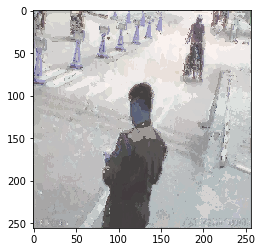

In [176]:
img = cv2.resize(cv2.imread('../../Dataset/camera4/JPEGImages/00001.jpg'), (256,256))
# img = cv2.resize(cv2.imread('../../sample2.jpg'), (224,224))
datav = torch.from_numpy( np.array([img.transpose( (2, 0, 1) ).astype('float32')/255.]) )
datav = Variable(datav)
if(use_cuda):
    datav = datav.cuda()
output = model(datav)[0][0]
_, labels_pred = torch.max(output,0)
im_target_rgb = color.label2rgb(labels_pred.cpu().numpy()%200, img, kind = 'rgb')
plt.imshow(im_target_rgb*1)

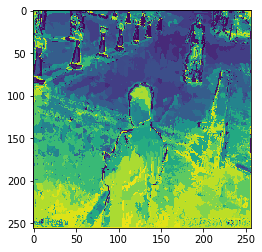

In [198]:
plt.imshow(labels_pred.cpu().numpy())
plt.savefig('optiflow01.png')

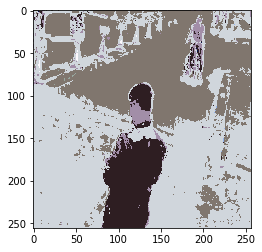

In [178]:
g = graph.rag_mean_color(im_target_rgb, labels_pred.cpu().numpy(), mode='similarity')
labels2 = graph.cut_normalized(labels_pred.cpu().numpy(), g,thresh=0.1)
out2 = color.label2rgb(labels2, im_target_rgb*2, kind='avg')

plt.imshow(out2*2)
plt.savefig('optiflow02.png')

In [170]:
output.shape

torch.Size([500, 256, 256])

In [ ]:
torch.save(model.state_dict(), 'model.h5')